In [26]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [27]:
import numpy as np
from scipy.optimize import minimize
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt



def obj_loss_function(params, X, y, lamb):
    w0 = params[-1]  
    w = params[:-1]  
    w = w[:,None]


    log_loss = np.sum(np.logaddexp(0, (- y * (X @ w + w0))))


    reg_term = 0.5 * lamb * float(w.T @ w)
    total_loss = log_loss + reg_term

    return total_loss


def minBinDev(X, y, lamb):
    n,d = X.shape
    initial_params = np.ones(d + 1) * lamb
    print(initial_params)

    sol = minimize(obj_loss_function, initial_params, args=(X, y, lamb))

    if not sol.success:
        print("Warning: Optimization did not converge. Check your data or parameters.")


    w = sol['x'][:-1][:, None]  # make it d-by-1
    w0 = sol['x'][-1]
    print(w)
    print(w0)

    return w, w0




In [28]:
#prereq
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt


def linearKernel(X1, X2):
    return X1 @ X2.T


def polyKernel(X1, X2, degree):
    return (X1 @ X2.T + 1) ** degree


def gaussKernel(X1, X2, width):
    distances = cdist(X1, X2, 'sqeuclidean')
    return np.exp(- distances / (2*(width**2)))


def generateData(n, gen_model):

    # Controlling the random seed will give you the same 
    # random numbers every time you generate the data. 
    # The seed controls the internal random number generator (RNG).
    # Different seeds produce different random numbers. 
    # This can be handy if you want reproducible results for debugging.
    # For example, if your code *sometimes* gives you an error, try
    # to find a seed number (0 or others) that produces the error. Then you can
    # debug your code step-by-step because every time you get the same data.

    # np.random.seed(0)  # control randomness when debugging

    if gen_model == 1 or gen_model == 2:
        # Gen 1 & 2
        d = 2
        w_true = np.ones([d, 1])

        X = np.random.randn(n, d)

        if gen_model == 1:
            y = np.sign(X @ w_true)  # generative model 1
        else:
            y = np.sign((X ** 2) @ w_true - 1)  # generative model 2

    elif gen_model == 3:
        # Gen 3
        X, y = generateMoons(n)

    else:
        raise ValueError("Unknown generative model")

    return X, y


def generateMoons(n, noise=0.1):
    n_samples_out = n // 2
    n_samples_in = n - n_samples_out
    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_out))
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_out))
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_in))
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_samples_in)) - 0.5

    X = np.vstack(
        [np.append(outer_circ_x, inner_circ_x), 
         np.append(outer_circ_y, inner_circ_y)]
    ).T
    X += np.random.randn(*X.shape) * noise

    y = np.hstack(
        [-np.ones(n_samples_out, dtype=np.intp), 
         np.ones(n_samples_in, dtype=np.intp)]
    )[:, None]
    return X, y


def plotPoints(X, y):
    # plot the data points from two classes
    X0 = X[y.flatten() >= 0]
    X1 = X[y.flatten() < 0]

    plt.scatter(X0[:, 0], X0[:, 1], marker='x', label='class -1')
    plt.scatter(X1[:, 0], X1[:, 1], marker='o', label='class +1')
    return


def getRange(X):
    x_min = np.amin(X[:, 0]) - 0.1
    x_max = np.amax(X[:, 0]) + 0.1
    y_min = np.amin(X[:, 1]) - 0.1
    y_max = np.amax(X[:, 1]) + 0.1
    return x_min, x_max, y_min, y_max


def plotModel(X, y, w, w0, classify):

    plotPoints(X, y)

    # plot model
    x_min, x_max, y_min, y_max = getRange(X)
    grid_step = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    z = classify(np.c_[xx.ravel(), yy.ravel()], w, w0)

    # Put the result into a color plot
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.RdBu, alpha=0.5)
    plt.legend()
    plt.show()
    return


def plotAdjModel(X, y, a, a0, kernel_func, adjClassify):

    plotPoints(X, y)

    # plot model
    x_min, x_max, y_min, y_max = getRange(X)
    grid_step = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    z = adjClassify(np.c_[xx.ravel(), yy.ravel()], a, a0, X, kernel_func)

    # Put the result into a color plot
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.RdBu, alpha=0.5)
    plt.legend()
    plt.show()
    return


def plotDualModel(X, y, a, b, lamb, kernel_func, dualClassify):

    plotPoints(X, y)

    # plot model
    x_min, x_max, y_min, y_max = getRange(X)
    grid_step = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    z = dualClassify(np.c_[xx.ravel(), yy.ravel()], a, b, X, y, 
                     lamb, kernel_func)

    # Put the result into a color plot
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.RdBu, alpha=0.5)
    plt.legend()
    plt.show()

    return


def plotDigit(x):
    img = x.reshape((28, 28))
    plt.imshow(img, cmap='gray')
    plt.show()
    return

In [29]:
#q1b

def minHinge(X, y, lamb, stabilizer=1e-5):
    n,d = X.shape

    y = y.flatten()

    #P in (P,q,G,h)
    P = np.zeros((n+d+1,n+d+1))

    #P[:d, :d] = lamb * np.eye(d)  # Regularization on the weights


    #for size of dimensioanlity, create that size identity matrix in the top left
    P[:d, :d] = lamb * np.eye(d)

    #q = d+1 zeroes, n 1's
    q = np.hstack([np.zeros(d+1), np.ones(n)])

    #G matrix: 2n rows for the slack variables for 2 constraints
    G = np.zeros((2*n, d+1+n))

    #first constraint, G11 (could be 0)
    G[:n, :d] = -y[:, None] * X

    #g12 for w0 (could also be 0)
    G[:n,d]= -y

    #g13, Iden matrix (prob good)
    G[:n,d+1:]= -np.eye(n) #mario agrees

    #second contraint 
    G[n:, d+1:] = -np.eye(n) #mario agrees

    #h, constraint for G, so 2n rows to match, 0n and -1n.
    h = np.hstack([-np.ones(n), np.zeros(n)]) 

    P += stabilizer * np.eye(d+1+n)
    #P = matrix(P + (stabilizer * np.eye(d*n+1)))

    P = matrix(P)
    q = matrix(q)
    G = matrix(G)
    h = matrix(h)

    solution = solvers.qp(P,q,G,h)

    w = np.array(solution['x'][:d])
    w0 = np.array(solution['x'][d]).item()

    return w,w0




In [30]:

def classify(Xtest, w, w0):
    return np.sign(Xtest @ w + w0)

In [31]:
def generateData(n, gen_model):

    # Controlling the random seed will give you the same 
    # random numbers every time you generate the data. 
    # The seed controls the internal random number generator (RNG).
    # Different seeds produce different random numbers. 
    # This can be handy if you want reproducible results for debugging.
    # For example, if your code *sometimes* gives you an error, try
    # to find a seed number (0 or others) that produces the error. Then you can
    # debug your code step-by-step because every time you get the same data.

    # np.random.seed(0)  # control randomness when debugging

    if gen_model == 1 or gen_model == 2:
        # Gen 1 & 2
        d = 2
        w_true = np.ones([d, 1])

        X = np.random.randn(n, d)

        if gen_model == 1:
            y = np.sign(X @ w_true)  # generative model 1
        else:
            y = np.sign((X ** 2) @ w_true - 1)  # generative model 2

    elif gen_model == 3:
        # Gen 3
        X, y = generateMoons(n)

    else:
        raise ValueError("Unknown generative model")

    return X, y


def generateMoons(n, noise=0.1):
    n_samples_out = n // 2
    n_samples_in = n - n_samples_out
    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_out))
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_out))
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_in))
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_samples_in)) - 0.5

    X = np.vstack(
        [np.append(outer_circ_x, inner_circ_x), 
         np.append(outer_circ_y, inner_circ_y)]
    ).T
    X += np.random.randn(*X.shape) * noise

    y = np.hstack(
        [-np.ones(n_samples_out, dtype=np.intp), 
         np.ones(n_samples_in, dtype=np.intp)]
    )[:, None]
    return X, y

In [32]:

#q1d

def compute_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


def synExperimentsRegularize():

    n_runs = 100 
    n_train = 100  
    n_test = 1000  

    lamb_list = [0.001, 0.01, 0.1, 1.0]  
    gen_model_list = [1, 2, 3]  

    train_acc_bindev = np.zeros((len(lamb_list), len(gen_model_list), n_runs))
    test_acc_bindev = np.zeros((len(lamb_list), len(gen_model_list), n_runs))
    train_acc_hinge = np.zeros((len(lamb_list), len(gen_model_list), n_runs))
    test_acc_hinge = np.zeros((len(lamb_list), len(gen_model_list), n_runs))

    for r in range(n_runs):
        for i, lamb in enumerate(lamb_list):
            for j, gen_model in enumerate(gen_model_list):

                Xtrain, ytrain = generateData(n=n_train, gen_model=gen_model)
                Xtest, ytest = generateData(n=n_test, gen_model=gen_model)

                
                # Binary deviance loss (part a)
                w, w0 = minBinDev(Xtrain, ytrain, lamb)
                ytrain_pred = classify(Xtrain, w, w0)  
                ytest_pred = classify(Xtest, w, w0)  

                train_acc_bindev[i, j, r] = compute_accuracy(ytrain, ytrain_pred)

                train_acc_bindev[i, j, r] = compute_accuracy(ytrain, ytrain_pred)
                test_acc_bindev[i, j, r] = compute_accuracy(ytest, ytest_pred)

                # Hinge loss (part b)
                w, w0 = minHinge(Xtrain, ytrain, lamb)
                ytrain_pred = classify(Xtrain, w, w0)  # Predict on training set
                ytest_pred = classify(Xtest, w, w0)  # Predict on test set
                # Store accuracies
                train_acc_hinge[i, j, r] = compute_accuracy(ytrain, ytrain_pred)
                test_acc_hinge[i, j, r] = compute_accuracy(ytest, ytest_pred)

    # Compute average 
    avg_train_acc_bindev = np.mean(train_acc_bindev, axis=2)
    avg_test_acc_bindev = np.mean(test_acc_bindev, axis=2)
    avg_train_acc_hinge = np.mean(train_acc_hinge, axis=2)
    avg_test_acc_hinge = np.mean(test_acc_hinge, axis=2)

    # Combine accuracies
    train_acc = np.hstack([avg_train_acc_bindev, avg_train_acc_hinge])
    test_acc = np.hstack([avg_test_acc_bindev, avg_test_acc_hinge])

    return train_acc, test_acc


acc1,acc2 = synExperimentsRegularize()

print(acc1)
print(acc2)

     pcost       dcost       gap    pres   dres
 0: -6.5406e+01  2.7140e+02  2e+03  5e+00  2e+01
 1:  1.3666e+02 -1.0568e+02  3e+02  7e-01  3e+00
 2:  4.4576e+01 -1.2109e+00  5e+01  7e-02  3e-01
 3:  1.8771e+01  1.0849e+01  9e+00  1e-02  5e-02
 4:  1.6408e+01  1.3521e+01  3e+00  3e-03  1e-02
 5:  1.5194e+01  1.4676e+01  5e-01  4e-04  2e-03
 6:  1.4962e+01  1.4908e+01  6e-02  1e-05  6e-05
 7:  1.4936e+01  1.4933e+01  3e-03  5e-07  2e-06
 8:  1.4934e+01  1.4934e+01  3e-05  5e-09  2e-08
 9:  1.4934e+01  1.4934e+01  3e-07  5e-11  2e-10
Optimal solution found.
Optimized weights: [2.04667527 2.43772331]
Optimized bias: -0.08170782118237549


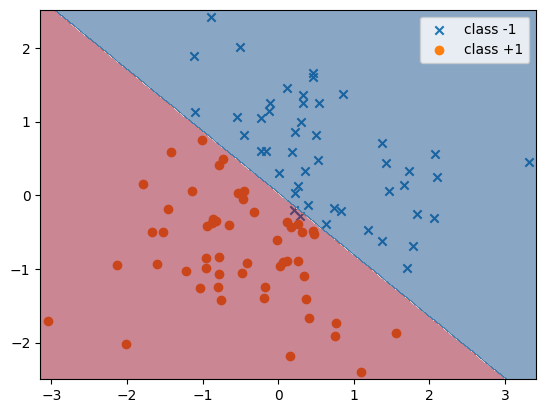

In [39]:
#visual test

def polyKernel(X1, X2, degree):
    return (X1 @ X2.T + 1) ** degree

X,y = generateData(100,1)
lamb = 1# Regularization parameter

kernel_func = lambda X1, X2 : polyKernel(X1,X2,2)

w, w0 = minHinge(X, y, lamb)

print("Optimized weights:", w.flatten())
print("Optimized bias:", w0)

plotModel(X,y,w,w0,classify)